In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Import libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Loading and preprocessing

In [ ]:
# Specify the file path or URL of the CSV file
csv_file_path = '/content/drive/MyDrive/datasets/MLA4H_A2/hypotension_patients.csv'

# Load the CSV file into a DataFrame
df_orig = pd.read_csv(csv_file_path)

# Display the DataFrame
df_orig.head()

,ID,anchor_age,gender,dod,apsiii,LoS,charlson_comorbidity_index
0,1,80,F,NaN,56,7.00,4
1,2,72,F,2137-09-02,49,12.92,6
2,3,82,M,2144-06-18,46,13.13,5
3,4,89,F,2155-12-07,86,4.92,7
4,5,69,F,2136-05-12,102,11.46,8


In [ ]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5106 entries, 0 to 5105
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          5106 non-null   int64  
 1   anchor_age                  5106 non-null   int64  
 2   gender                      5106 non-null   object 
 3   dod                         3290 non-null   object 
 4   apsiii                      5106 non-null   int64  
 5   LoS                         5106 non-null   float64
 6   charlson_comorbidity_index  5106 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 279.4+ KB


In [ ]:
df = df_orig.copy()

"""--- DATA PREPROCESSING ---

We employ preprocessing techniques to convert all data into numerical format.
This involves substituting the variable 'dod' with the label 'survived', where a value of 1 indicates survival and 0 indicates death.
Similarly, for the variable 'gender', we assign the value 0 to represent female and 1 to represent male.

"""
df['gender'] = df_orig['gender'].map({'F': 0, 'M': 1})

df.rename(columns={'dod': 'survived'}, inplace=True)
df['survived'] = df['survived'].apply(lambda x: 0 if pd.notnull(x) else 1).astype(int)


In [ ]:
df.head()

,ID,anchor_age,gender,survived,apsiii,LoS,charlson_comorbidity_index
0,1,80,0,1,56,7.00,4
1,2,72,0,0,49,12.92,6
2,3,82,1,0,46,13.13,5
3,4,89,0,0,86,4.92,7
4,5,69,0,0,102,11.46,8


#1- Describe the main properties of the profound hypotension cohort

,anchor_age,gender,survived,apsiii,LoS,charlson_comorbidity_index
count,5106.000000,5106.000000,5106.00000,5106.000000,5106.000000,5106.00000
mean,65.552683,0.558754,0.35566,60.314532,7.053651,5.21700
std,15.235907,0.496585,0.47876,28.860171,8.432716,2.57691
min,18.000000,0.000000,0.00000,3.000000,0.040000,0.00000
25%,56.000000,0.000000,0.00000,38.000000,1.960000,4.00000
50%,67.000000,1.000000,0.00000,53.000000,4.130000,5.00000
75%,77.000000,1.000000,1.00000,78.000000,8.960000,7.00000
max,91.000000,1.000000,1.00000,189.000000,103.500000,19.00000


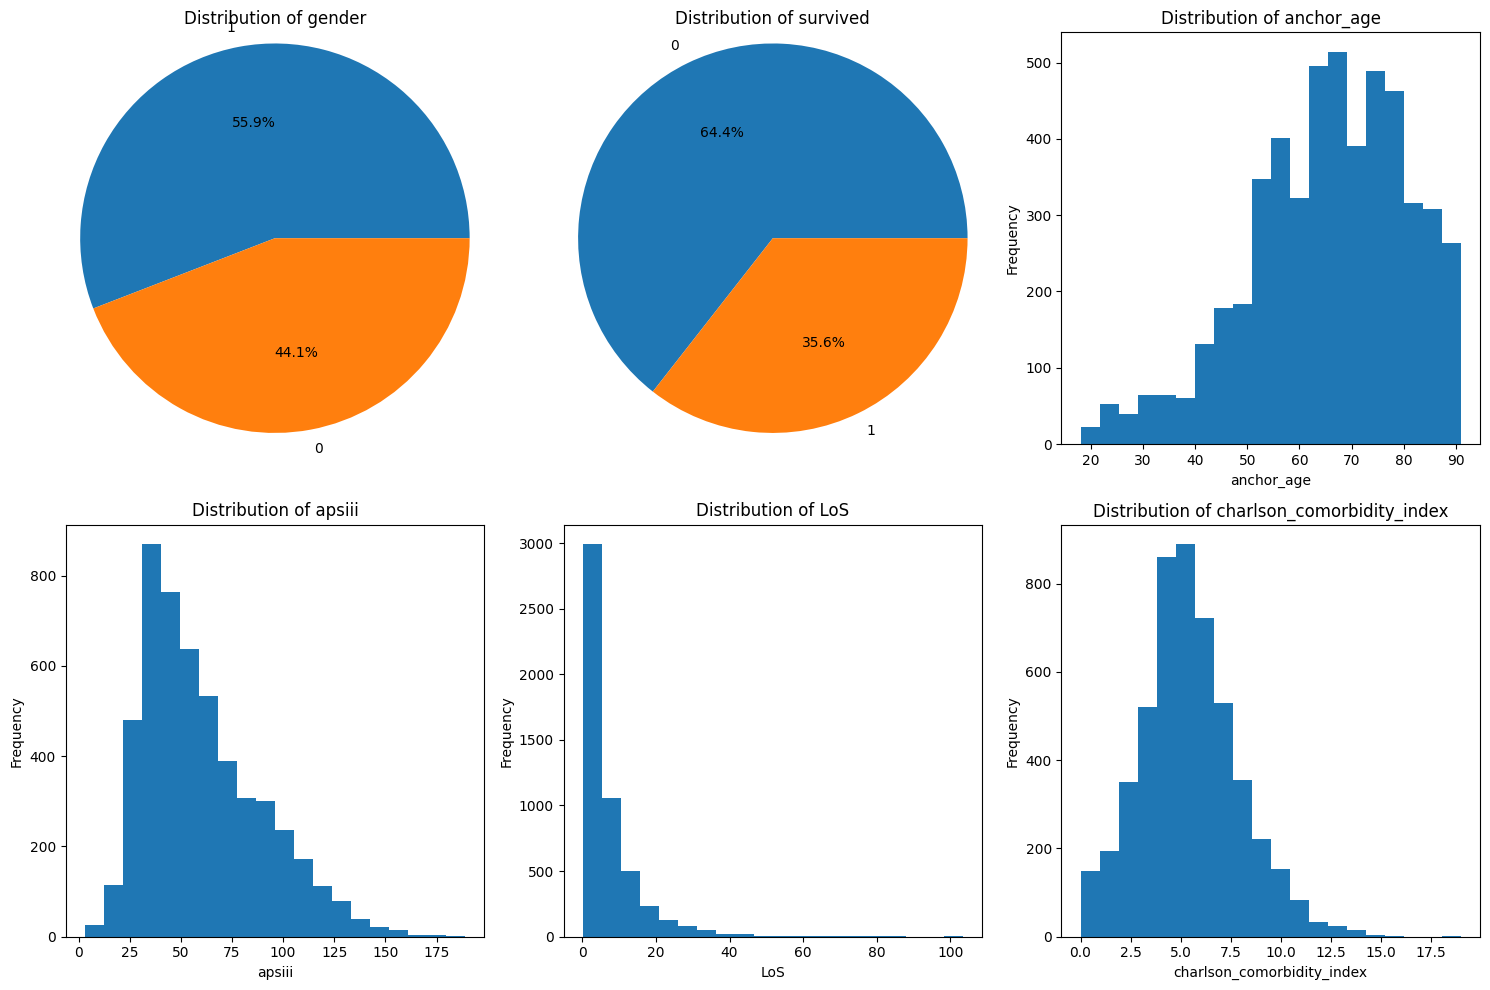

In [ ]:
'''display summary statistics'''

summary_stats = df.drop('ID', axis=1).describe()
display(summary_stats)

''' plot figures '''

# figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot bar plots for categorical variables (excluding binary variables)
def plot_categorical(variable, ax):
    df[variable].value_counts().plot(kind='bar', ax=ax)
    ax.set_xlabel(variable)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {variable}')

# Plot pie chart for binary variables
def plot_binary(variable, ax):
    counts = df[variable].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%')
    ax.set_title(f'Distribution of {variable}')
    ax.axis('equal')

# Plot histogram for numerical variables
def plot_numerical(variable, ax):
    ax.hist(df[variable], bins=20)
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {variable}')

# Plotting
plot_binary('gender', axes[0, 0])
plot_binary('survived', axes[0, 1])
plot_numerical('anchor_age', axes[0, 2])
plot_numerical('apsiii', axes[1, 0])
plot_numerical('LoS', axes[1, 1])
plot_numerical('charlson_comorbidity_index', axes[1, 2])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


The analyzed ICU cohort comprised patients admitted for profound hypotension. The patients ranged from 18-91 years old, with a mean age of 66. The cohort had a relatively higher proportion of older patients (>50 years) and a male majority (56%).

Notably, 64% of patients did not survive their ICU stay, highlighting the high mortality risk associated with hypotension. Severity scores (APSIII) ranged from 3-189 (mean 60, median 53) and show moderate right-skew, indicating heterogeneity in acuity levels. The average APSIII score suggests moderately high severity. Length of ICU stay also varied substantially, with an average of 7 days but median of 4 days. The distribution was right-skewed featuring outliers exceeding 100 days, so while most stays were less than a week, some endured prolonged ICU admissions.

Considering the age of the patients, comorbidity index scores tended to be moderate to high (mean 5.2, median 5). This indicates comorbid conditions may have contributed to the need for admission, though the profound hypotension itself seemed to be the primary factor necessitating critical care treatment.

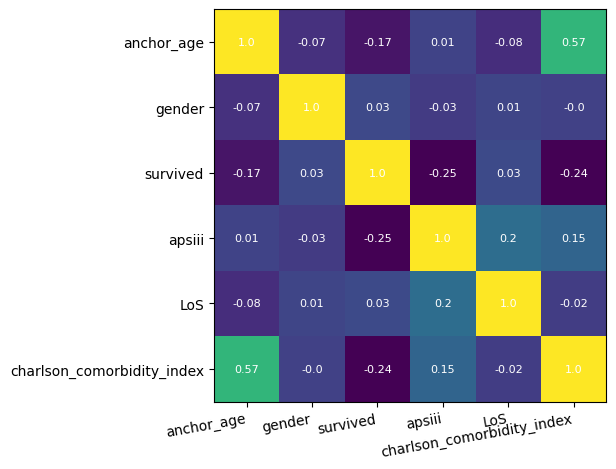

In [ ]:
# Get all numeric columns except 'ID'
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [col for col in num_cols if col != 'ID']

# Calculate correlation matrix
corr = df[num_cols].corr()

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(corr)

# Show values in squares
for i in range(len(corr)):
    for j in range(len(corr)):
        value = round(corr.iloc[i, j], 2)
        text = ax.text(j, i, value,
                       ha="center", va="center", color="w", fontsize=8)

ax.set_xticks(np.arange(len(corr)))
ax.set_yticks(np.arange(len(corr)))
ax.set_xticklabels(corr.columns, rotation=10, ha='right')
ax.set_yticklabels(corr.columns)

fig.tight_layout()
plt.show()

The heatmap showed negative correlations between surviving and age/APSIII, revealing lower survival for older patients and those with higher severity scores. There was a strong positive correlation between age and comorbidities, showing older patients generally had more comorbidities.

#2- Perform k-means clustering to identify subgroups of patients

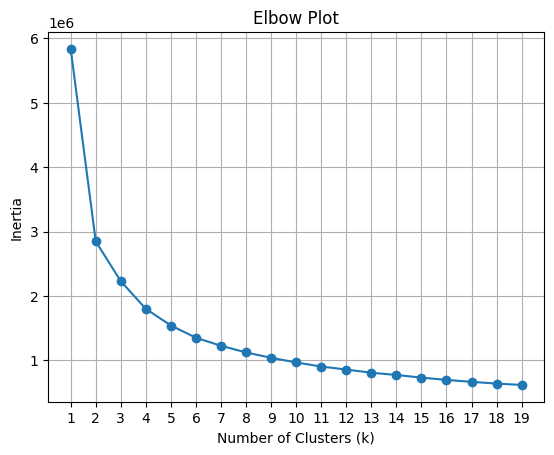

In [ ]:
# Select all features except ID
features = [col for col in df.columns if col != 'ID']
X = df[features]

# Initialize an empty list to store the inertia values
inertia_values = []

# Define the range of clusters to try
k_values = range(1, 20)

# Perform k-means clustering for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(list(k_values), inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.xticks(list(k_values))
plt.grid(True)
plt.show()


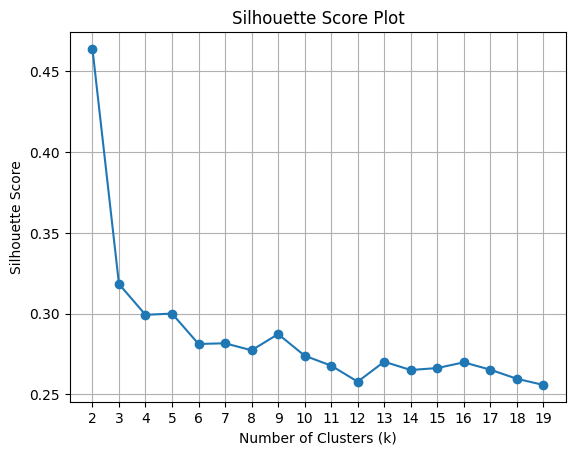

In [ ]:
# Select all features except ID
features = [col for col in df.columns if col != 'ID']
X = df[features]

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Define the range of clusters to try
k_values = range(2, 20)

# Perform k-means clustering for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels))


# Plot the silhouette scores
plt.plot(list(k_values), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Plot')
plt.xticks(list(k_values))
plt.grid(True)
plt.show()


We performed K-means clustering to identify subgroups of hypotensive patients. The elbow plot shows the inertia (sum of squared distances to cluster centers) decreasing as more clusters are added. The elbow point, where inertia decrease sharply levels off, indicates an appropriate number of clusters that balances model complexity and performance.

The elbow is not definitive, so silhouette analysis was also used to evaluate clustering coherence. The silhouette score measures how similar samples are to their own cluster versus other clusters, with scores near 1 indicating well-matched clusters.

Based on the elbow point flattening after k=2-3 clusters, and reviewing silhouette scores, k=2 and k=3 were selected for further analysis. The elbow plot shows inertia continuing to decrease after k=3, but with diminishing returns. The silhouette score of 0.46 for k=2 indicates reasonable clustering, and the score of 0.32 for k=3 suggests somewhat coherent clusters still.

Although increasing the number of clusters could potentially decrease inertia, the decision to choose a lower number of clusters (k=2 and k=3) was guided by two factors: the identification of the elbow point and the desire for interpretability. Additionally, the diminishing silhouette scores further supported the choice to keep the number of clusters low. By considering these two specific numbers of clusters, we strike a balance between model performance and interpretability in this exploratory analysis aimed at identifying meaningful subgroups among patients. By evaluating differences in key variables across the clusters, we can gain insights into whether these clusters exhibit distinct phenotypes that are related to risk or outcomes.

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
clusters = kmeans.fit_predict(X)
# Add cluster labels to dataframe
df['cluster_2'] = clusters

kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
clusters = kmeans.fit_predict(X)
# Add cluster labels to dataframe
df['cluster_3'] = clusters

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5106 entries, 0 to 5105
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          5106 non-null   int64  
 1   anchor_age                  5106 non-null   int64  
 2   gender                      5106 non-null   int64  
 3   survived                    5106 non-null   int64  
 4   apsiii                      5106 non-null   int64  
 5   LoS                         5106 non-null   float64
 6   charlson_comorbidity_index  5106 non-null   int64  
 7   cluster_2                   5106 non-null   int32  
 8   cluster_3                   5106 non-null   int32  
dtypes: float64(1), int32(2), int64(6)
memory usage: 319.2 KB


#3- Main property differences between the identified clusters + relation to outcomes

 K=2: 



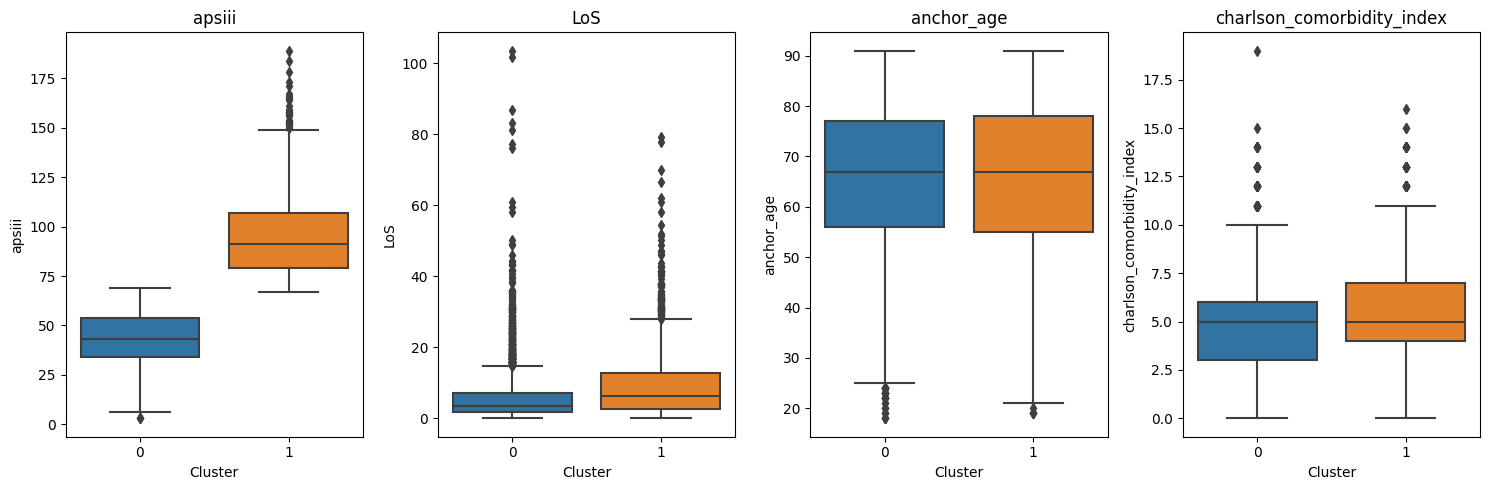



 K=3: 



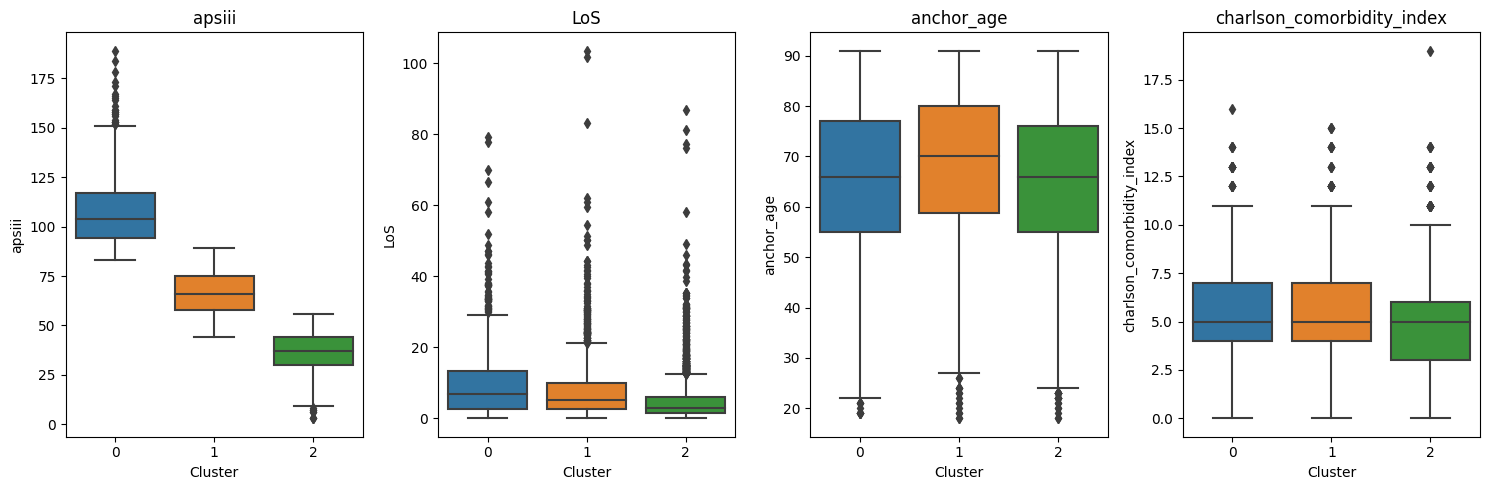



 SURVIVAL RATE: 



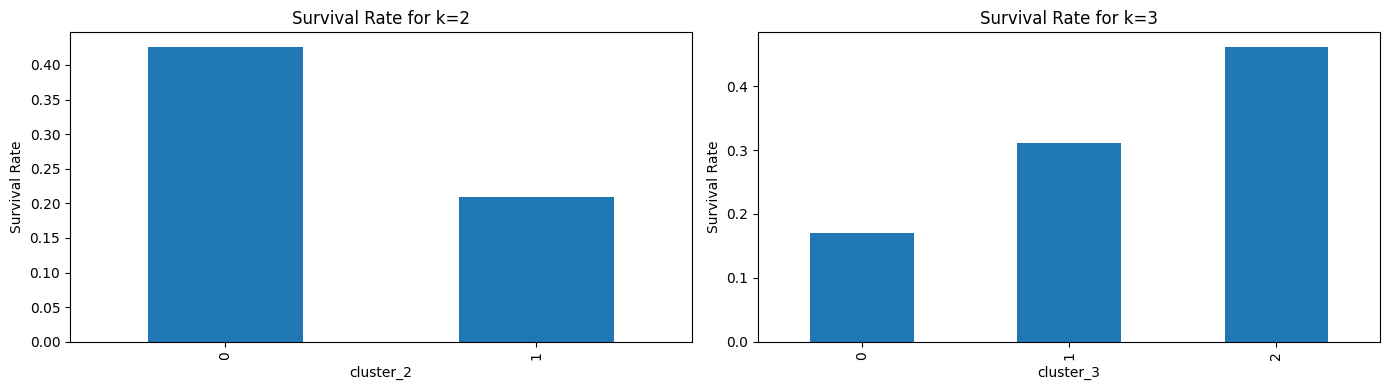

In [ ]:
# List of variables to plot
variables = ['apsiii','LoS', 'anchor_age', 'charlson_comorbidity_index']

'''PLOT FOR K=2'''

print(" K=2: \n")

# Create a figure with subplots
fig, axes = plt.subplots(1, len(variables), figsize=(15, 5))

# Loop over the variables
for i, var in enumerate(variables):
    # Create box plots for k=2
    sns.boxplot(x='cluster_2', y=var, data=df, ax=axes[i])
    axes[i].set_title(var)
    axes[i].set_xlabel('Cluster')


# Adjust spacing between subplots
plt.tight_layout()
plt.show()

'''PLOT FOR K=3'''

print("\n\n K=3: \n")

# Create a figure with subplots
fig, axes = plt.subplots(1, len(variables), figsize=(15, 5))

# Loop over the variables
for i, var in enumerate(variables):
    # Create box plots for k=2
    sns.boxplot(x='cluster_3', y=var, data=df, ax=axes[i])
    axes[i].set_title(var)
    axes[i].set_xlabel('Cluster')


# Adjust spacing between subplots
plt.tight_layout()
plt.show()

'''PLOT FOR SURVIVAL RATE'''

print("\n\n SURVIVAL RATE: \n")

plt.figure(figsize=(14, 4))

# plot survival rate for K=2
plt.subplot(1, 2, 1)
df.groupby('cluster_2')['survived'].mean().plot(kind='bar')
plt.ylabel('Survival Rate')
plt.title('Survival Rate for k=2')

# plot survival rate for K=3
plt.subplot(1, 2, 2)
df.groupby('cluster_3')['survived'].mean().plot(kind='bar')
plt.ylabel('Survival Rate')
plt.title('Survival Rate for k=3')

plt.tight_layout()
plt.show()

Our k-means clustering analysis, performed with k=2 and k=3, has identified distinct patient subgroups within the cohort.

For k=2, Cluster 0, characterized by a lower mean apsiii score of 45 and shorter ICU stays (mean LoS of 6 days), represents less severely ill patients. In contrast, Cluster 1, with a higher mean apsiii score of 95 and longer ICU stays (mean LoS over 9 days), represents more severely ill patients. Interestingly, survival rates align with these distinctions, with Cluster 0 exhibiting a higher survival rate (over 40%) than Cluster 1 (20%).

For k=3, the clusters provide a more nuanced view. Cluster 0 represents the most critically ill patients, with the highest mean apsiii score of 110 and longest ICU stays (mean LoS of 10 days), resulting in the lowest survival rate (17%). Cluster 1, with a mean apsiii score of 65, represents moderately ill patients and has a survival rate of over 30%. Cluster 2, with the lowest mean apsiii score of 35 and shortest ICU stays (mean LoS of 5 days), represents less severely ill patients and has the highest survival rate (over 45%).

While age and comorbidity index show less pronounced differences across clusters for both k=2 and k=3, these factors are not entirely insignificant. Clusters with the highest survival rates tend to comprise individuals with slightly lower comorbidity levels. This suggests that while older patients generally have more comorbidities, those with fewer comorbidities may have a better chance of survival, influencing their cluster assignment. This relationship adds complexity to our understanding of patient subgroups.

In conclusion, our analysis has identified meaningful patient subgroups primarily differentiated by severity of illness and length of stay in ICU. These factors correlate with patient outcomes, providing valuable insights for risk stratification and treatment strategies in profound hypotension.